# 前処理色々

ライブラリのインポート

In [355]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.sparse.linalg import cg
from scipy.sparse import diags
from tqdm.auto import tqdm
from numba import njit

各種パラメータ

In [356]:
#グリッドについて
n_grid = 1024 # number of grid points
right_edge = 1024 # right edge of the simulation box
dx = 1 # grid spacing
grid = np.arange(n_grid+1) * dx # 0, 1, ..., 1024
grid_half = (np.arange(n_grid) + 0.5) * dx # 0.5, 1.5, ..., 1023.5

#粒子について
density_per_cell = 4 # particles per cell
n_particle = n_grid * density_per_cell # total number of particles
n_e = density_per_cell * dx * (1/2) # number of electrons
e = 1/n_e # 電荷素量    
m = np.ones(n_particle) 
q = np.ones(n_particle) 
m_ion = 100
q[0::2] = e # ion
q[1::2] = -e # electron
m[0::2] = m_ion * e
m[1::2] = 1.0 * e

# シミュレーションパラメータ
v_e = 1.0  # 電子の熱速度
v_ion = v_e * np.sqrt(1/m_ion) # イオンの熱速度
epsilon = 1.0   # 真空の誘電率
c = 50.0 # 光速
mu = 1.0 / (epsilon * c**2) # 真空の透磁率
theta = 0.505 # imlicitnessパラメータ

#時間について
dt = 0.01 # time step
tmax = 100 # maximum time
t = 0.0
n_step = int(tmax / dt)

初期条件の設定

In [357]:
#粒子の初期配置
x = 1024 * (np.random.rand(n_particle))
y = np.zeros(n_particle)
z = np.zeros(n_particle)
u = np.zeros(n_particle)
v = np.zeros(n_particle)
w = np.zeros(n_particle)
u[0::2] = v_ion/3 * np.random.randn(n_particle//2)  # イオンの速度(偶数index)
u[1::2] = v_e/3 * np.random.randn(n_particle//2)    # 電子の速度(奇数index)
v[0::2] = v_ion/3 * np.random.randn(n_particle//2)
v[1::2] = v_e/3 * np.random.randn(n_particle//2)
w[0::2] = v_ion/3 * np.random.randn(n_particle//2)
w[1::2] = v_e/3 * np.random.randn(n_particle//2)

# 電場, 磁場の初期条件
def magnetic_field(x, y):
    Bx = 0.0 * np.ones_like(y)
    By = 0.0 * np.ones_like(y)
    Bz = 1.0 * np.ones_like(y)
    Ex = 0.0* np.sin(2 * np.pi * y / 128)
    Ey = 0.0 * np.ones_like(x)
    Ez = 0.0 * np.ones_like(x)
    return Bx, By, Bz, Ex, Ey, Ez
Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid = magnetic_field(grid, grid_half) #グリッド上での磁場と電場

# 各種関数

速度の更新(Buneman-Boris法)

In [358]:
# 電磁場の補完
def field_interpolation(x, n_grid, Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid):
    # ---- half-grid -> grid への置き直し（元コードと同じ規則）
    # avg[i] = (grid[i] + grid[i+1]) / 2 （i=n_grid-1 は first に巻き戻し）
    # さらに元コードは i=n_grid でも (0,1) の平均を入れているので末尾に同じ値を付ける
    def half_to_grid(arr):
        avg = 0.5 * (arr + np.roll(arr, -1))          # shape (n_grid,)
        return np.concatenate([avg, avg[:1]])          # shape (n_grid+1,)

    Bx_on_grid = half_to_grid(Bx_grid)
    By_on_grid = half_to_grid(By_grid)
    Bz_on_grid = half_to_grid(Bz_grid)
    Ex_on_grid = half_to_grid(Ex_grid)

    # ---- 粒子位置の周期折り返し（元コードと同じ）
    L = n_grid * dx
    xi_p = np.mod(x, L)                               # shape (Np,)

    ig  = (xi_p // dx).astype(np.int64)               # 0..n_grid-1
    igp = (ig + 1) % n_grid

    xg = ig * dx
    s1 = (xi_p - xg) / dx
    s0 = 1.0 - s1

    # ---- CIC補間（takeでインデックス参照をベクトル化）
    Ex_particles = s0 * np.take(Ex_on_grid, ig) + s1 * np.take(Ex_on_grid, igp)
    Ey_particles = s0 * np.take(Ey_grid,   ig) + s1 * np.take(Ey_grid,   igp)
    Ez_particles = s0 * np.take(Ez_grid,   ig) + s1 * np.take(Ez_grid,   igp)

    Bx_particles = s0 * np.take(Bx_on_grid, ig) + s1 * np.take(Bx_on_grid, igp)
    By_particles = s0 * np.take(By_on_grid, ig) + s1 * np.take(By_on_grid, igp)
    Bz_particles = s0 * np.take(Bz_on_grid, ig) + s1 * np.take(Bz_on_grid, igp)

    return Bx_particles, By_particles, Bz_particles, Ex_particles, Ey_particles, Ez_particles


# 速度の更新

def buneman_boris_push(u, v, w, q, m, dt, Ex, Ey, Ez, Bx, By, Bz):
    v_vec = np.stack([u, v, w], axis=1)          # (Np, 3)
    B_vec = np.stack([Bx, By, Bz], axis=1)       # (Np, 3)
    E_vec = np.stack([Ex, Ey, Ez], axis=1)       # (Np, 3)

    qm = (q / m)[:, None]                        # (Np, 1) ← これが重要

    T = qm * B_vec * (0.5 * dt)                  # (Np, 3)
    T2 = np.sum(T * T, axis=1, keepdims=True)    # (Np, 1)
    S = 2.0 * T / (1.0 + T2)                     # (Np, 3)

    v_minus = v_vec + qm * E_vec * (0.5 * dt)    # (Np, 3)
    v_prime = v_minus + np.cross(v_minus, T)     # (Np, 3)
    v_plus  = v_minus + np.cross(v_prime, S)     # (Np, 3)
    v_new   = v_plus + qm * E_vec * (0.5 * dt)   # (Np, 3)

    return v_new[:, 0], v_new[:, 1], v_new[:, 2]


電荷保存法(Jxの計算に用いる)

In [359]:
@njit
def deposit_current_esirkepov(x_old, x_new, q, n_grid, dx, dt):
    Jx = np.zeros(n_grid+2)  # half grid

    for p in range(len(x_old)):
        xp0 = x_old[p]
        xp1 = x_new[p]
        dq = q[p]

        L = n_grid * dx
        xp0 = xp0 % L
        xp1 = xp1 % L

        # 最近接表現に直す（重要）
        dxp = xp1 - xp0
        if dxp >  L/2: xp1 -= L
        if dxp < -L/2: xp1 += L


        # 方向
        sgn = np.sign(xp1 - xp0)
        if sgn == 0:
            continue
        elif sgn > 0:
            A = xp0
            B = xp1
            C = 1
        else:
            A = xp1
            B = xp0
            C = -1

        i0 = int(xp0 // dx)
        i1 = int(xp1 // dx)

        if xp1 > xp0:
            cells = range(i0, i1+1)
        else:
            cells = range(i1, i0+1)

        for k in cells: # AからBまでのセルをループ, Cは方向
            xL = max(A, k*dx)
            xR = min(B, (k+1)*dx)
            dl = xR - xL
            if dl > 0:
                Jx[(k+1) % n_grid] += dq * C * dl / (dt * dx) # 境界を飛び越えても対応

    return Jx

CIC法による電荷散布(Jy, Jzの計算に用いる)

In [360]:
# 重みの計算
def lower_index(x, grid):
    idx = np.searchsorted(grid, x) - 1
    n_grid = len(grid) - 1
    return idx % n_grid


def deposit_charge(x, q, n_grid, dx, lower_idx, v, w, grid=grid, periodic=True):
    S   = np.zeros(n_grid+1)
    rho = np.zeros(n_grid+1)
    Jy  = np.zeros(n_grid+1)
    Jz  = np.zeros(n_grid+1)

    i0 = lower_idx.astype(np.int64)
    i1 = i0 + 1

    if periodic:
        # 右端に落ちた i1==n_grid+1 を 1 へ巻く等、あなたの格子定義に合わせて調整可能
        # いまは「0..n_grid-1 を周期」とみなして巻き、配列(n_grid+1)の末端はゴースト的に残す形
        i0 = i0 % n_grid
        i1 = i1 % n_grid

    xi = (x - grid[i0]) / dx
    s1 = xi
    s0 = 1.0 - xi

    # S
    np.add.at(S, i0, s0)
    np.add.at(S, i1, s1)

    # rho
    inv_dx = 1.0 / dx
    np.add.at(rho, i0, q * s0 * inv_dx)
    np.add.at(rho, i1, q * s1 * inv_dx)

    # Jy, Jz
    np.add.at(Jy, i0, q * v * s0 * inv_dx)
    np.add.at(Jy, i1, q * v * s1 * inv_dx)
    np.add.at(Jz, i0, q * w * s0 * inv_dx)
    np.add.at(Jz, i1, q * w * s1 * inv_dx)

    return S, rho, Jy, Jz


1D陰的FDTD法

In [361]:
def implicit_FDTD_1d(Bx_grid, By_grid, Bz_grid,
                               Ex_grid, Ey_grid, Ez_grid,
                               grid, grid_half, n_grid,
                               Jx, Jy, Jz,
                               A=None):
    """
    元コードの意味（ip0=i%n_grid で参照）を保ったまま、
    (n_grid), (n_grid+1), (n_grid+2) が混在しても落ちないベクトル化版。
    """

    def core(f):
        # 元コードの ip0=i%n_grid（i=0..n_grid-1）に対応する部分だけ使う
        return np.asarray(f)[:n_grid]

    Bx = core(Bx_grid); By = core(By_grid); Bz = core(Bz_grid)
    Ey = core(Ey_grid); Ez = core(Ez_grid)
    Jy0 = core(Jy); Jz0 = core(Jz)
    Jx0 = core(Jx)

    # 2階差分（周期）
    lap = lambda f: (np.roll(f, -1) - 2.0*f + np.roll(f, 1)) / (dx*dx)
    # 後方差分（周期）: (f[i]-f[i-1])/dx
    back_diff = lambda f: (f - np.roll(f, 1)) / dx

    b_x = theta * (c*dt)**2 * lap(Bx)

    b_y = theta * (c*dt)**2 * lap(By) \
          - theta * (dt*dt)/epsilon * back_diff(Jz0) \
          + dt * back_diff(Ez)

    b_z = theta * (c*dt)**2 * lap(Bz) \
          + theta * (dt*dt)/epsilon * back_diff(Jy0) \
          - dt * back_diff(Ey)

    # 平均除去（元コード通り）
    b_x -= np.mean(b_x)
    b_y -= np.mean(b_y)
    b_z -= np.mean(b_z)

    # 行列 A（固定なら外で1回作って渡すと速い）
    alpha2 = (theta * c * dt / dx)**2
    if A is None:
        main = (1 + 2*alpha2) * np.ones(n_grid)
        off  = -alpha2 * np.ones(n_grid)
        A = diags([off, main, off], [-1, 0, 1], shape=(n_grid, n_grid), format="csr")
        A = A.tolil()
        A[0, -1] = -alpha2
        A[-1, 0] = -alpha2
        A = A.tocsr()

    delta_Bx, info_bx = cg(A, b_x, rtol=1e-10, maxiter=1000)
    delta_By, info_by = cg(A, b_y, rtol=1e-10, maxiter=1000)
    delta_Bz, info_bz = cg(A, b_z, rtol=1e-10, maxiter=1000)

    # delta_Ex は元コードで i=0..n_grid-1 に代入してるだけ
    delta_Ex = -(dt/epsilon) * Jx0
    delta_Ex -= np.mean(delta_Ex)

    # delta_Ey, delta_Ez：元コードは range(n_grid+1) で ip0=i%n_grid なので
    # 「最後の要素は 0番と同じ」になる。ベクトルで再現する。
    dBz  = (np.roll(Bz, -1) - Bz) / dx
    dBy  = (np.roll(By, -1) - By) / dx
    dDBz = (np.roll(delta_Bz, -1) - delta_Bz) / dx
    dDBy = (np.roll(delta_By, -1) - delta_By) / dx

    delta_Ey_core = -(dt/epsilon) * core(Jy) + (c**2) * (dt * (-dBz) + dt*theta * (-dDBz))
    delta_Ez_core = -(dt/epsilon) * core(Jz) + (c**2) * (dt * ( dBy) + dt*theta * ( dDBy))

    delta_Ey = np.concatenate([delta_Ey_core, delta_Ey_core[:1]])  # (n_grid+1,)
    delta_Ez = np.concatenate([delta_Ez_core, delta_Ez_core[:1]])  # (n_grid+1,)

    return delta_Bx, delta_By, delta_Bz, delta_Ex, delta_Ey, delta_Ez



# メインループ

In [362]:
lower_idx = lower_index(x, grid)
S, rho, Jy, Jz = deposit_charge(x, q, n_grid, dx, lower_idx, v, w)
j = np.arange(len(Ex_grid))
Ng = len(grid) - 1
# Poisson方程式に整合するように電場を修正
for i in range(n_particle):
        k = lower_idx[i]
        kp = k % Ng
        kp1 = (k + 1) % Ng
        Ex_grid[j-1 < kp]     += - q[i] / (2 * epsilon)
        Ex_grid[j-1 == kp]  += q[i] / (2 * epsilon) * (S[kp] - S[kp1])
        Ex_grid[j-1 > kp]   += q[i] / (2 * epsilon)
Ex_grid -= np.mean(Ex_grid)  # 平均値を引く

In [363]:
t_list = []
kinetic_list = []
electric_list = []
magnetic_list = []
total_list = []

In [364]:
step = 0
pbar = tqdm(total=n_step, desc="PIC", unit="step", dynamic_ncols=True)
while t < tmax and step < n_step:
    #エネルギーの計算
    kinetic = 0.5 * np.sum(m * (u**2 + v**2 + w**2)) # 運動エネルギー
    electric = 0.5 * epsilon * (np.sum(Ex_grid**2) + np.sum(Ey_grid**2) + np.sum(Ez_grid**2)) * dx # 電場エネルギー
    magnetic = 0.5 * (1/mu) * (np.sum(Bz_grid**2) + np.sum(By_grid**2) + np.sum((Bx_grid)**2)) * dx # 磁場エネルギー
    total = kinetic + electric + magnetic
    # データの保存
    t_list.append(t)
    kinetic_list.append(kinetic)
    electric_list.append(electric)
    magnetic_list.append(magnetic)
    total_list.append(total)

    # 電磁場の補完
    Bx_particles, By_particles, Bz_particles, Ex_particles, Ey_particles, Ez_particles = field_interpolation(x, n_grid, Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid)

    # 速度の更新
    u, v, w = buneman_boris_push(u, v, w, q, m, dt, Ex_particles, Ey_particles, Ez_particles, Bx_particles, By_particles, Bz_particles)

    # 位置の更新
    x_old = np.copy(x)
    x += u * dt

    # xについて周期境界条件
    x = x % right_edge
    x_old = x_old % right_edge

    # 電流の堆積
    Jx = deposit_current_esirkepov(x_old, x, q, n_grid, dx, dt)

    lower_indexs = lower_index(x, grid)
    S,rho, Jy, Jz = deposit_charge(x, q, n_grid, dx, lower_indexs, v, w)
    # 電磁場の更新
    delta_Bx, delta_By, delta_Bz, delta_Ex, delta_Ey, delta_Ez = implicit_FDTD_1d(Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid, grid, grid_half, n_grid, Jx, Jy, Jz)

    Bx_grid += delta_Bx
    By_grid += delta_By
    Bz_grid += delta_Bz
    Ex_grid += delta_Ex
    Ey_grid += delta_Ey
    Ez_grid += delta_Ez

    t += dt
    step += 1
    pbar.update(1)
    if step % 100 == 0:
        pbar.set_postfix(t=f"{t:.3g}", E=f"{total:.3e}")
pbar.close()

PIC:   0%|          | 0/10000 [00:00<?, ?step/s]

# プロット

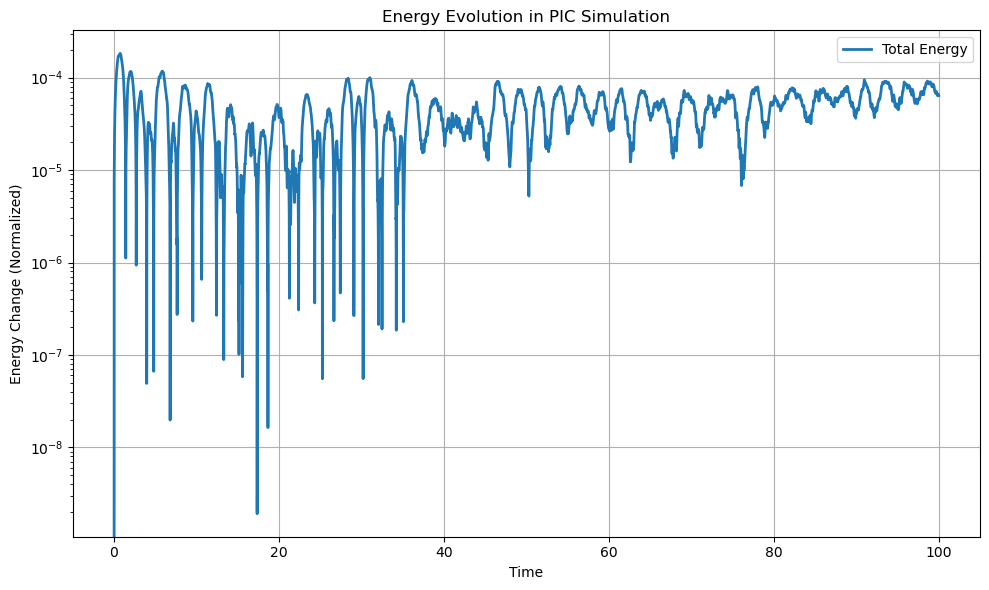

In [365]:
#nomalizeした全エネルギーの時間発展をプロット
plt.figure(figsize=(10,6))

plt.plot(
        t_list,
        abs(total_list-total_list[0]) / (kinetic_list[0] + electric_list[0] + magnetic_list[0]),
        label="Total Energy",
        linewidth=2
    )

plt.yscale("log")

plt.xlabel("Time")
plt.ylabel("Energy Change (Normalized)")
plt.legend()
plt.title("Energy Evolution in PIC Simulation")
plt.grid()
plt.tight_layout()
plt.show()